# POC1: Core chatbot workflow

- Read and parse PDF document.
- Chunk documents and metadata extraction.
- Proper index.
- Proper retrieving, node postprocessing and response synthesing.

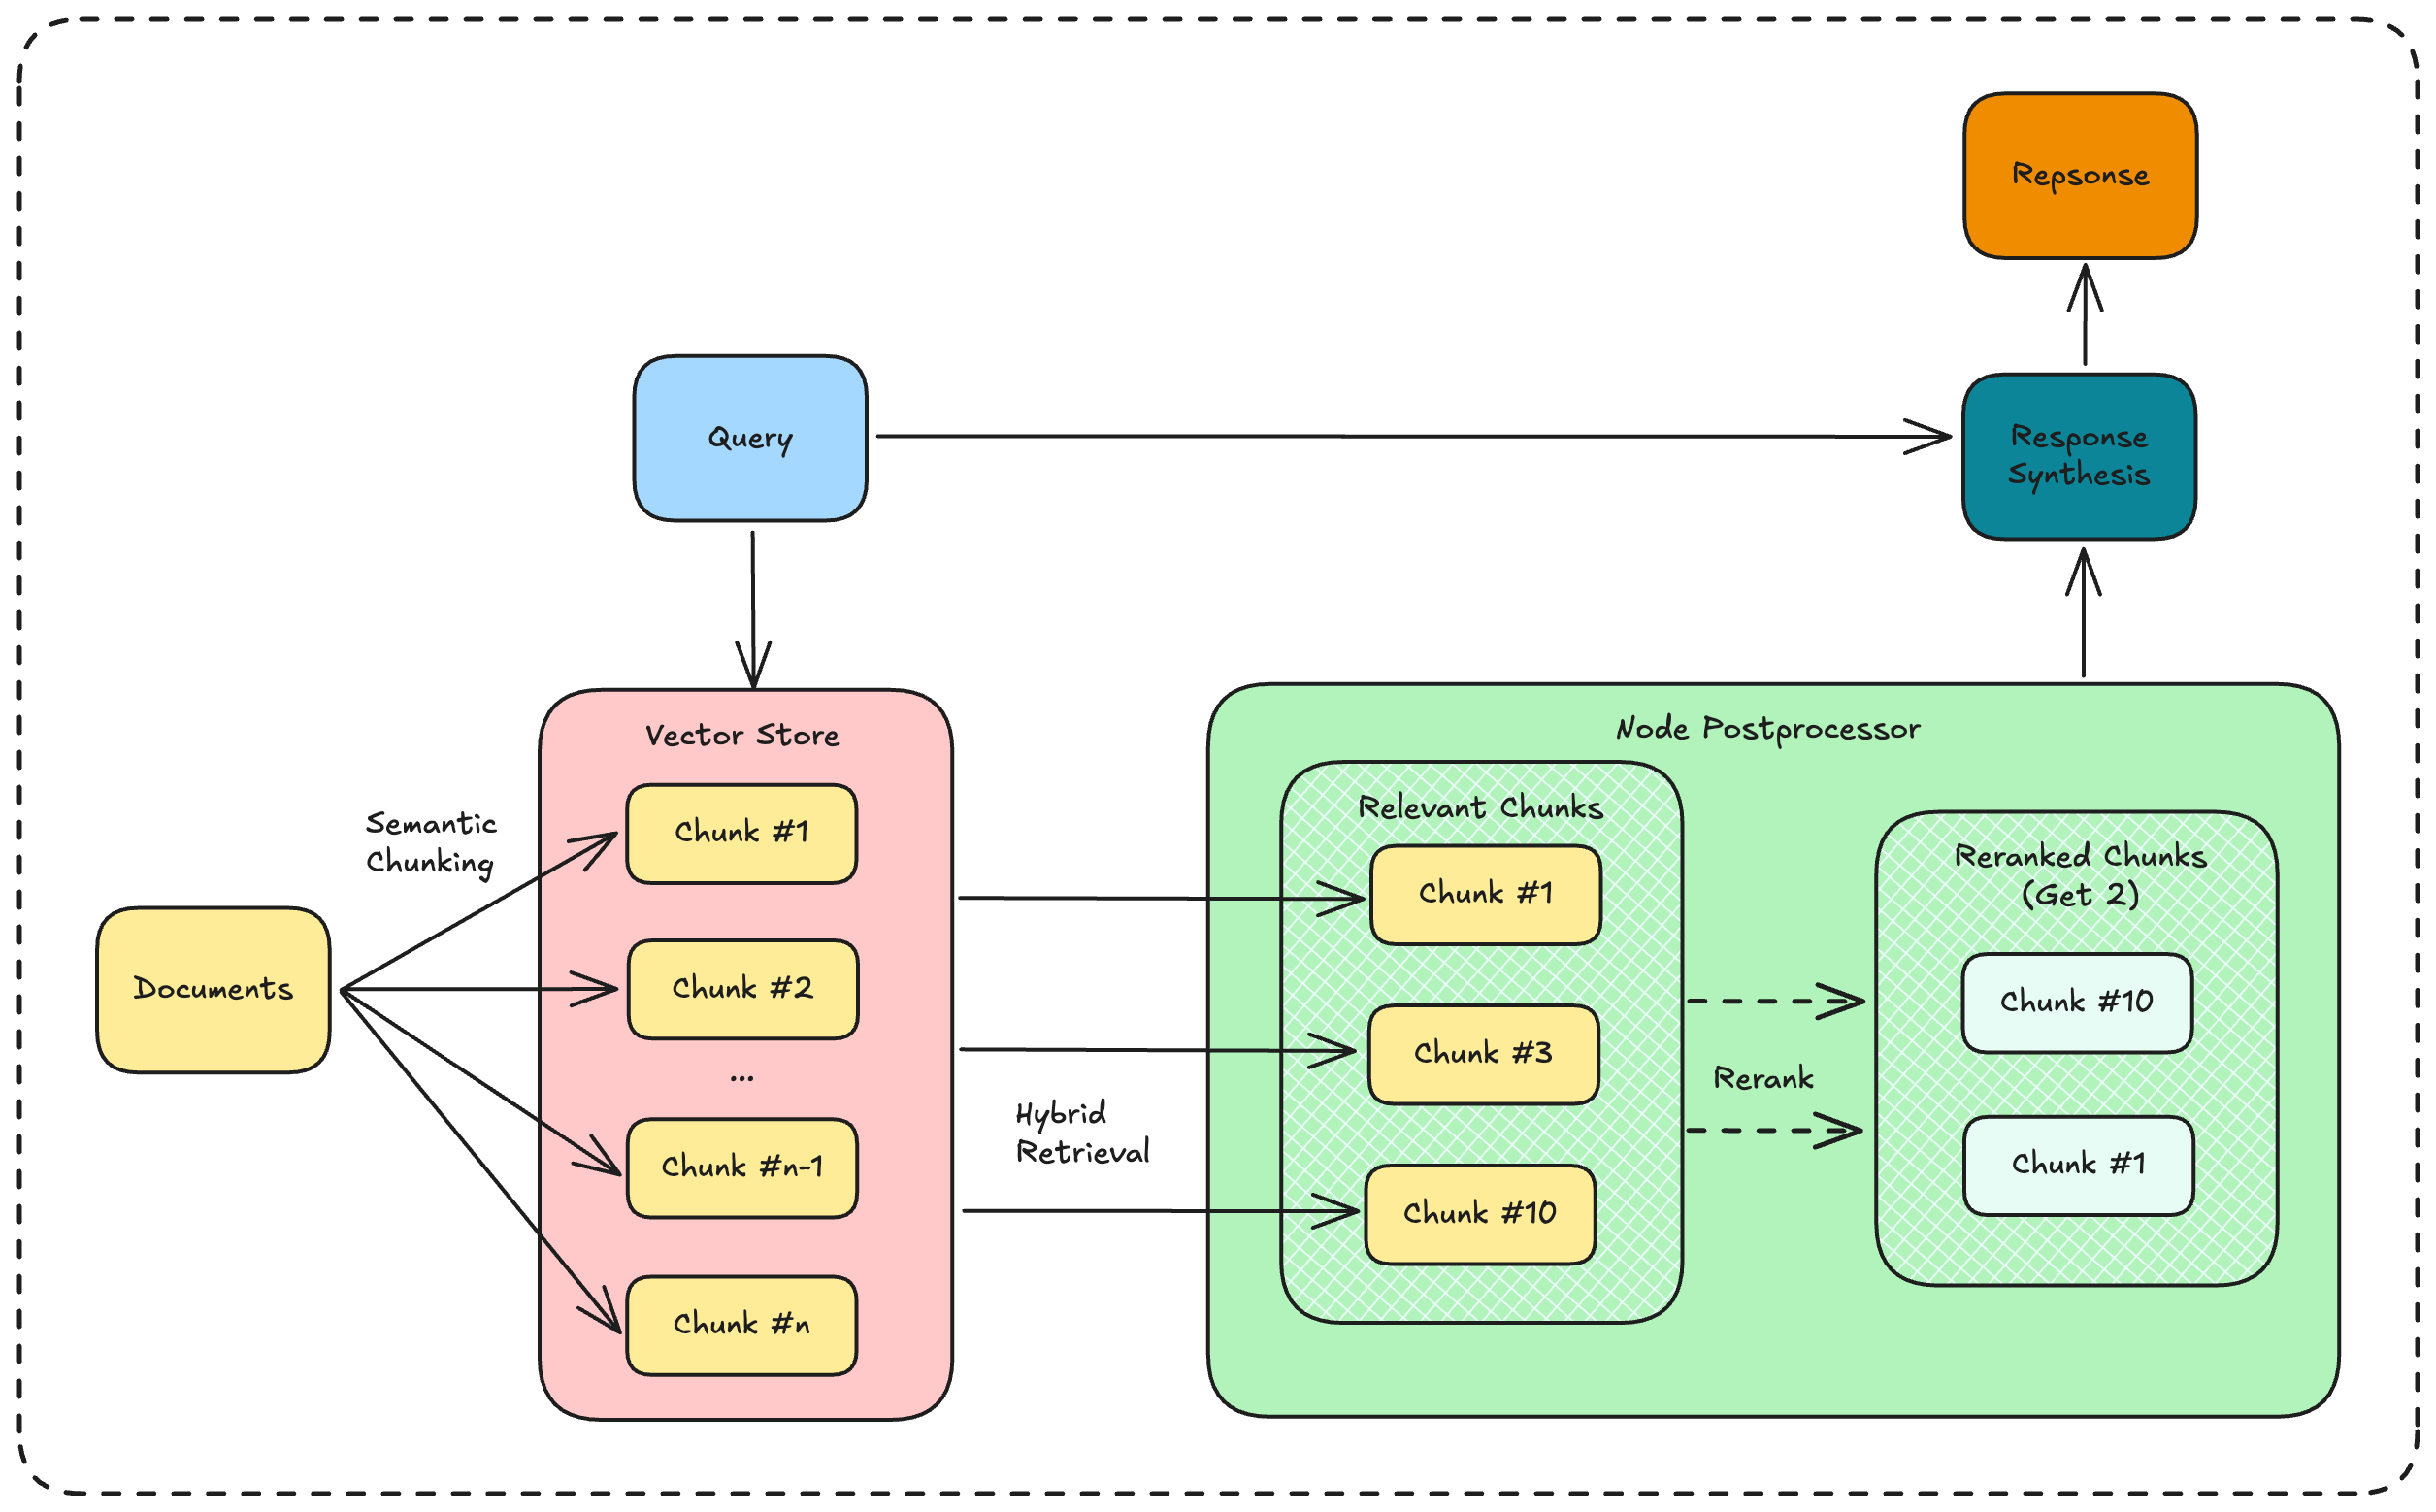

# important dont delete

In [1]:
# %pip install --quiet --upgrade --force --disable-pip-version-check llama-index-vector-stores-qdrant llama-index fastembed llama-index-storage-chat-store-redis llama-index-core redis llama-index-storage-kvstore-redis

## Read and parse PDF document

The reason for not directly using llamaindex's SimpleDirectoryReader is because when reading it, there is an encoding error, for example as follows:
- "Căn c ứ vào B ộ Luật lao đ ộng số 45/2019/QH14  ngày 20/11/2019;"

So here we decided to use the pdfplumber library as an intermediary for loading the pdf file to return a txt file that has been saved in the correct 'utf-8' format for more accurate chunking. The result after using the pdfplumber library:
- "Căn cứ vào Bộ Luật lao động số 45/2019/QH14 ngày 20/11/2019;"

Reasons for choosing pdfplumber library instead of other pdf reading libraries such as:
- PyPDF2 (still causes encoding errors)
- PyMuPDF (fitz) (supports many other complex functions but not needed yet)
- Tesseract OCR (not needed yet)

There will be 2 versions here: 1 version to work with folder and 1 version to work directly with a single file.

**Làm với folder**

In [ ]:
import os
import pdfplumber
from llama_index.core import SimpleDirectoryReader
from typing import List
import tempfile


def process_pdf_folder(folder_path: str) -> List:
    """
    Load and parse all PDF files in a folder using SimpleDirectoryReader

    Args:
    folder_path (str): Path to the folder containing PDF files

    Returns:
    List: Documents from SimpleDirectoryReader
    """
    # Get a list of all PDF files in a folder
    pdf_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".pdf")]

    if not pdf_files:
        raise ValueError(f"No PDF files found in the folder {folder_path}")

    # Create temporary folder in memory
    with tempfile.TemporaryDirectory() as temp_dir:
        # Process individual PDF files
        for pdf_file in pdf_files:
            pdf_path = os.path.join(folder_path, pdf_file)
            temp_text_file = os.path.join(
                temp_dir, f"{os.path.splitext(pdf_file)[0]}.txt"
            )

            try:
                # Read PDF and save to temporary text file
                with pdfplumber.open(pdf_path) as pdf:
                    text = ""
                    for page in pdf.pages:
                        text += page.extract_text()

                with open(temp_text_file, "w", encoding="utf-8") as f:
                    f.write(text)

            except Exception as e:
                print(f"Lỗi khi xử lý file {pdf_file}: {str(e)}")
                continue

        # Use SimpleDirectoryReader to read all text files
        documents = SimpleDirectoryReader(temp_dir).load_data()

    # Temp directory is automatically deleted when the with block ends
    return documents


def main():
    folder_path = "C:\\Users\\trungpt\\Documents\\trungpt\\project_1\\raw"

    try:
        # process pdf file in folder
        documents = process_pdf_folder(folder_path)
        print(f"Total documents processed: {len(documents)}")
        return documents
    except Exception as e:
        print(f"error: {str(e)}")
        return None


if __name__ == "__main__":
    documents = main()

# print(documents)

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


**làm với file**

In [ ]:
# %pip install pdfplumber
# %pip install llama_index

In [ ]:
import os
import pdfplumber
from llama_index.core import SimpleDirectoryReader
from typing import List
import tempfile


def process_single_pdf(pdf_path: str) -> List:
    """
    Load and parse a specific PDF file using SimpleDirectoryReader

    Args:
    pdf_path (str): Path to the PDF file to process

    Returns:
    List: Documents from SimpleDirectoryReader
    """
    # Check file existence
    if not os.path.exists(pdf_path):
        raise FileNotFoundError(f"File not found: {pdf_path}")

    # Check file extension
    if not pdf_path.lower().endswith(".pdf"):
        raise ValueError(f"File {pdf_path} is not a PDF file")

    # Tạo thư mục tạm trong bộ nhớ
    with tempfile.TemporaryDirectory() as temp_dir:
        try:
            # Create temporary folder in memory
            pdf_filename = os.path.basename(pdf_path)
            temp_text_file = os.path.join(
                temp_dir, f"{os.path.splitext(pdf_filename)[0]}.txt"
            )

            # Load PDF and save to temporary text file
            with pdfplumber.open(pdf_path) as pdf:
                text = ""
                for page in pdf.pages:
                    text += page.extract_text()

            with open(temp_text_file, "w", encoding="utf-8") as f:
                f.write(text)

            print(f"File processed: {pdf_filename}")

            # Use SimpleDirectoryReader to read text files
            documents = SimpleDirectoryReader(temp_dir).load_data()

        except Exception as e:
            raise Exception(f"Error processing file {pdf_filename}: {str(e)}")

    return documents


def main():
    pdf_path = "/content/drive/MyDrive/raw_data/pdf/TULD02.pdf"

    try:
        # process pdf file
        documents = process_single_pdf(pdf_path)
        print(f"Complete")
        return documents
    except Exception as e:
        print(f"Error: {str(e)}")
        return None


if __name__ == "__main__":
    documents = main()

# print(documents)

File processed: TULD02.pdf
Complete


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


## Define LLM Model and Embedding Model

In [ ]:
import os
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import Settings

In [ ]:
if "google.colab" in str(get_ipython()):
    from google.colab import userdata

    os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
else:
    if os.getenv("OPENAI_API_KEY") == None:
        raise ValueError("OPENAI_API_KEY not set")

In [ ]:
from llama_index.core import SimpleDirectoryReader

input_dir = "data/"

documents = SimpleDirectoryReader(
    input_dir=input_dir,
    required_exts=[".txt", ".pdf"],
    recursive=True,
    exclude_hidden=True,
).load_data(show_progress=True)

In [ ]:
from llama_index.embeddings.openai import OpenAIEmbeddingMode

# Initialize the LLM
llm = OpenAI(model="gpt-4o-mini", temperature=0)

# Initialize the LLM embeddings
embed_model = OpenAIEmbedding(
    mode=OpenAIEmbeddingMode.TEXT_SEARCH_MODE,
    model="text-embedding-3-small",
    embed_batch_size=100,
    dimensions=768,
)

# Global settings
Settings.llm = llm
Settings.embed_model = embed_model
Settings.num_output = 1024
Settings.context_window = 128_000

## Define Vector Database (Qdrant)

In [ ]:
from llama_index.vector_stores.qdrant import QdrantVectorStore
from qdrant_client import QdrantClient

In [ ]:
client = QdrantClient(location=":memory:", asynchronous=True)
vector_store = QdrantVectorStore(
    client=client, collection_name="lmao", enable_hybrid=True
)

## Ingestion & Chunking & Indexing Pipeline

In [ ]:
from llama_index.core.ingestion import IngestionPipeline, IngestionCache
from llama_index.core.extractors import (
    QuestionsAnsweredExtractor,
    KeywordExtractor,
)
from llama_index.storage.kvstore.redis import RedisKVStore as RedisCache
from llama_index.core.node_parser import SemanticSplitterNodeParser

In [ ]:
# Init the cache store
ingest_cache = IngestionCache(
    cache=RedisCache(host="127.0.0.1", port=6379), collection="lmao_cache"
)

In [ ]:
import nest_asyncio

nest_asyncio.apply()

extractors = [
    QuestionsAnsweredExtractor(llm=Settings.llm, questions=2),
    KeywordExtractor(llm=Settings.llm, keywords=10),
]

semantic_splitter = SemanticSplitterNodeParser(
    buffer_size=1, breakpoint_percentile_threshold=95, embed_model=Settings.embed_model
)

transformations = [semantic_splitter] + extractors

pipeline = IngestionPipeline(
    transformations=transformations,
    vector_store=vector_store,
    # cache=ingest_cache,
)
pipeline.run(documents=documents, show_progress=True, batch_size=64)

## Retrieval

In [ ]:
docstore = SimpleDocumentStore()
docstore.add_documents(pipeline.nodes)

storage_context = StorageContext.from_defaults(
    docstore=docstore,
    vector_store=vector_store,
)

In [ ]:
from llama_index.core.retrievers import BM25Retriever

# Create BM25 Retriever from docstore
bm25_retriever = BM25Retriever.from_defaults(docstore=docstore, similarity_top_k=5)

In [ ]:
from llama_index.core.retrievers import QueryFusionRetriever

hybrid_retriever = QueryFusionRetriever(
    retrievers=[
        VectorStoreIndex(nodes=[], storage_context=storage_context).as_retriever(
            similarity_top_k=5
        ),
        bm25_retriever,
    ],
    num_queries=1,
    use_async=True,
)

## Node Postprocessor

In [ ]:
from llama_index.core.postprocessor import SentenceEmbeddingOptimizer
from llama_index.core.postprocessor import EmbeddingRecencyPostprocessor
from llama_index.core.postprocessor import LLMRerank


node_postprocessors = [
    SentenceEmbeddingOptimizer(
        embed_model=Settings.embed_model,
        # percentile_cutoff=0.5,
        threshold_cutoff=0.7,
    ),
    EmbeddingRecencyPostprocessor(date_key="date", similarity_cutoff=0.7),
    LLMRerank(top_n=2),
]

## Response Synthesis + Query Engine

In [ ]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import get_response_synthesizer
from llama_index.core.response_synthesizers.type import ResponseMode

# Configure response synthesizer
response_synthesizer = get_response_synthesizer(
    llm=Settings.llm, response_mode=ResponseMode.COMPACT
)

# assemble query engine
query_engine = RetrieverQueryEngine(
    retriever=hybrid_retriever,
    response_synthesizer=response_synthesizer,
    node_postprocessors=node_postprocessors,
)

In [ ]:
from llama_index.core import PromptTemplate
from llama_index.core.llms import ChatMessage, MessageRole

CUSTOM_PROMPT = PromptTemplate(
    """\
    Based on the conversation history between Human and Assistant, and a new question from the User,
    understand the question and consider the context of the conversation to generate an appropriate answer.
    The answer should be in Vietnamese, even though the question is in Vietnamese.
    Use tone professional like a Human Resource Manager.

    <Conversation History>
    {chat_history}

    <Current Question>
    {question}
    """
)

custom_chat_history = [
    ChatMessage(
        role=MessageRole.USER,
        content="Xin chào assistant, chúng ta đang có một cuộc trò chuyện về nội quy của doanh nghiệp.",
    ),
    ChatMessage(
        role=MessageRole.ASSISTANT,
        content="Tuyệt vời, bạn có muốn biết thêm thông tin về nội quy của doanh nghiệp không?",
    ),
]

In [ ]:
from llama_index.core.chat_engine import CondenseQuestionChatEngine

chat_engine = CondenseQuestionChatEngine.from_defaults(
    query_engine=query_engine,
    condense_question_prompt=CUSTOM_PROMPT,
    chat_history=custom_chat_history,
    verbose=True,
)

In [ ]:
query = "Hãy cho tôi biết có bao nhiêu hình thức xử lý vi phạm kỷ luật lao động được Công ty vận dụng theo quy định pháp luật lao động hiện hành ?"

response = chat_engine.chat(query)